## Exploratory Data Analysis (Keystroke Dataset)

In [241]:
from functools import partial

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interact_manual, widgets
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.metrics import r2_score, accuracy_score, classification_report, roc_curve, roc_auc_score, f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge
from sklearn.neural_network import MLPRegressor
from scipy import stats
from statsmodels.stats.multitest import multipletests
from tqdm.auto import tqdm
import seaborn as sns

In [242]:
%matplotlib widget
plt.style.use('./plt_style.txt')
cmap = sns.diverging_palette(220, 10, as_cmap=True)

In [362]:
# Read data from 'July' (September-October 2016)
keystrokes1 = pd.read_csv('July_dataset/july_IDE_data.csv', index_col=0)
# Filter out focus gained/lost and paste events as they're not present in the other dataset
keystrokes1 = keystrokes1[(keystrokes1.event_type != 'focus_gained') & (keystrokes1.event_type !=  'focus_lost') & (keystrokes1.event_type != 'text_paste')]
grades1 = pd.read_csv('July_dataset/july_points.csv', index_col=0)
keystrokes1['semester'] = 1
grades1['semester'] = 1
keystrokes1 = keystrokes1.set_index(['semester', keystrokes1.index])
grades1 = grades1.set_index(['semester', grades1.index])

# Read data from 'other semester' (September-October 2017)
keystrokes2 = pd.read_csv('Other semester/IDE_data.csv', index_col=0)
grades2 = pd.read_csv('Other semester/points.csv', index_col=0)
keystrokes2['semester'] = 2
grades2['semester'] = 2
keystrokes2 = keystrokes2.set_index(['semester', keystrokes2.index])
grades2 = grades2.set_index(['semester', grades2.index])

In [363]:
# Assign grading scheme to 'July' data
# Original grading scheme was:
# 63% of the grade was based on exercises (9% per week)
# 37% on three exams (10%, 12%, 15% for each exam)
# We are missing exams so can't obtain this
#grades1["original"] = (
#    grades1.part1 * 0.09 \
#    + grades1.part2 * 0.09
#    + grades1.part3 * 0.09
#    + grades1.part4 * 0.09
#    + grades1.part5 * 0.09
#    + grades1.part6 * 0.09
#    + grades1.part7 * 0.09
#    + grades1.exam1 * 0.1
#    + grades1.exam2 * 0.12
#    + grades1.exam3 * 0.15
#)
# Grading scheme which is equal for both semesters but based on the July dataset scheme
grades1["july_equal"] = (
    (grades1.part1 * 0.09 \
    + grades1.part2 * 0.09
    + grades1.part3 * 0.09
    + grades1.part4 * 0.09
    + grades1.part5 * 0.09
    + grades1.part6 * 0.09
    + grades1.part7 * 0.09) / 0.63
)
grades1["other_equal"] = (
    ((grades1.part1 >= 0.9) * 0.1 \
    + (grades1.part2 >= 0.9) * 0.1
    + (grades1.part3 >= 0.9) * 0.1
    + (grades1.part4 >= 0.9) * 0.1
    + (grades1.part5 >= 0.9) * 0.1
    + (grades1.part6 >= 0.9) * 0.1
    + (grades1.part7 >= 0.9) * 0.1) / 0.7
)

# Assign grading scheme to 'other semester' data
# Original grading scheme was:
# 70% on coursework (10% for each part if score >=90), 30% from two exams (10% and 20%)
grades2["original"] = (
    (grades2.part1 >= 0.9) * 0.1 \
    + (grades2.part2 >= 0.9) * 0.1
    + (grades2.part3 >= 0.9) * 0.1
    + (grades2.part4 >= 0.9) * 0.1
    + (grades2.part5 >= 0.9) * 0.1
    + (grades2.part6 >= 0.9) * 0.1
    + (grades2.part7 >= 0.9) * 0.1
    + grades2.exam1 * 0.1
    + grades2.exam2 * 0.2
)
# Grading scheme which is equal for both semesters but based on the other dataset scheme
grades2["other_equal"] = (
    ((grades2.part1 >= 0.9) * 0.1 \
    + (grades2.part2 >= 0.9) * 0.1
    + (grades2.part3 >= 0.9) * 0.1
    + (grades2.part4 >= 0.9) * 0.1
    + (grades2.part5 >= 0.9) * 0.1
    + (grades2.part6 >= 0.9) * 0.1
    + (grades2.part7 >= 0.9) * 0.1) / 0.7
)
grades2["july_equal"] = (
    (grades2.part1 * 0.09 \
    + grades2.part2 * 0.09
    + grades2.part3 * 0.09
    + grades2.part4 * 0.09
    + grades2.part5 * 0.09
    + grades2.part6 * 0.09
    + grades2.part7 * 0.09) / 0.63
)


keystrokes = pd.concat([keystrokes1, keystrokes2])
grades = pd.concat([grades1, grades2])

---

# Analysis

## Keystroke Summary

In [364]:
f"Number of student/class: {len(grades.index)}"

'Number of student/class: 574'

In [365]:
f"Number of events: {len(keystrokes.index)}"

'Number of events: 4176331'

In [253]:
keystrokes.event_type.value_counts()

text_insert     3115185
text_remove      965140
focus_gained     140058
focus_lost       136547
run               76900
text_paste        19643
submit            19106
Name: event_type, dtype: int64

**TODO:** Can we get paste events from the data as well?

## Grade Distributions

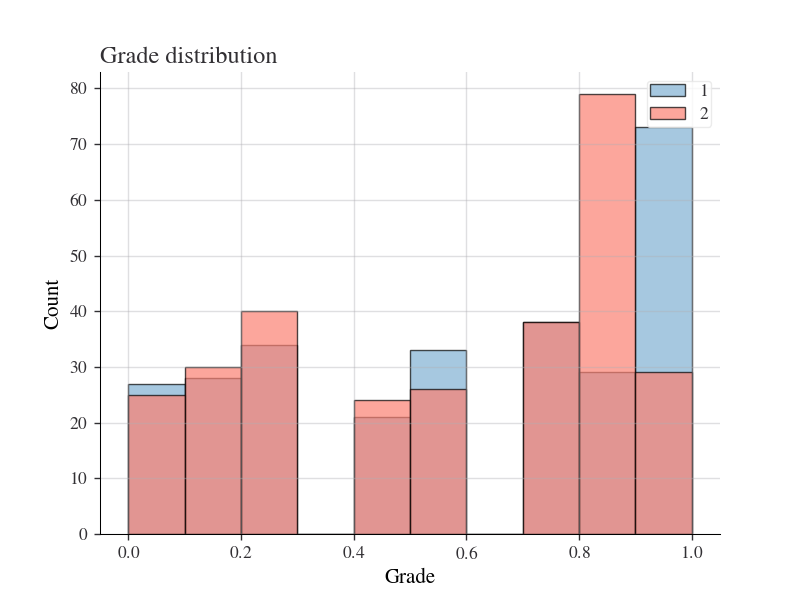

In [310]:
plt.figure()
for g, group in grades.groupby('semester'):
    plt.hist(group.other_equal, label=g, alpha=0.7)
plt.grid(alpha=0.4)
plt.xlabel('Grade')
plt.ylabel('Count')
plt.legend()
plt.title(f'Grade distribution')
plt.show()

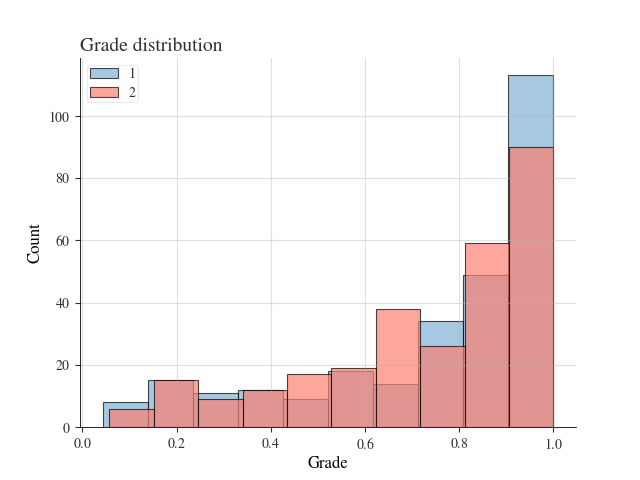

In [311]:
plt.figure(dpi=100)
for g, group in grades.groupby('semester'):
    plt.hist(group.july_equal, label=g, alpha=0.7)
plt.grid(alpha=0.4)
plt.xlabel('Grade')
plt.ylabel('Count')
plt.legend()
plt.title(f'Grade distribution')
plt.show()

## Summary Features

TODO: I'm not convinced this was correctly adapted from `EDA`, dealing with grouping in deeply nested multindexes is quite difficult.

In [366]:
groups = keystrokes.groupby(['semester', 'student', 'exercise'])

In [367]:
time_to_first_event = groups.time_to_deadline.max().unstack(level=-1)

In [368]:
time_to_last_event = groups.time_to_deadline.min().unstack(level=-1)

In [369]:
ks_submits = keystrokes.where(keystrokes.event_type == 'submit')
first_submit = ks_submits.groupby(['semester', 'student', 'exercise']).time_to_deadline.max().unstack(level=-1)

In [370]:
differences = -groups.apply(lambda g: g.sort_values('time_to_deadline', ascending=False).time_to_deadline.diff())

In [371]:
assert (~(differences[~differences.isna()] < 0)).all()

In [372]:
all_latencies = differences.groupby('student')

In [373]:
max_latency = differences.groupby('semester').quantile(0.995)#.loc[differences.index.get_level_values(0)]

In [374]:
filtered_latencies1 = differences.loc[1][differences.loc[1] < max_latency[1]]
filtered_latencies2 = differences.loc[2][differences.loc[2] < max_latency[2]]
filtered_latencies = pd.concat([filtered_latencies1, filtered_latencies2])

In [375]:
regrouped = filtered_latencies.groupby(['semester', 'student'])
mean_latency = regrouped.mean()
fine_time_on_task = regrouped.sum()

In [376]:
keystroke_counts = keystrokes.groupby(['semester', 'student']).event_type.apply(pd.value_counts).unstack(level=-1).fillna(0);

In [377]:
summary_features = keystroke_counts.assign(
    time_to_last = time_to_last_event.mean(axis=1),
    time_to_first=time_to_first_event.mean(axis=1),
    duration=(time_to_first_event-time_to_last_event).mean(axis=1),
    coarse_time_on_task=(time_to_first_event-first_submit).mean(axis=1),
    fine_time_on_task=fine_time_on_task,
    mean_latency=mean_latency
)
summary_features['coarse_time_on_task']=summary_features['coarse_time_on_task'].fillna(summary_features['coarse_time_on_task'].max()+100)
summary_features['mean_latency'] = summary_features['mean_latency'].fillna(0)
summary_features['fine_time_on_task'] = summary_features['fine_time_on_task'].fillna(0)
summary_features

run  submit  text_insert  text_remove   time_to_last  \
semester student                                                           
1        0        277.0    30.0      10746.0       3199.0  478773.310345   
         1        137.0    31.0       8209.0       1456.0  745662.366667   
         2         36.0    30.0       3389.0        922.0  687451.000000   
         3        135.0    29.0       3537.0       2072.0  283559.600000   
         4         63.0    30.0       5149.0       1680.0  389112.344828   
...                 ...     ...          ...          ...            ...   
2        286      195.0    35.0       5348.0        583.0  351342.531250   
         287      189.0    27.0       8840.0       3042.0  114496.222222   
         288      119.0    32.0       3793.0       1329.0   55836.125000   
         289      264.0    33.0      10503.0       3736.0  253266.281250   
         290       61.0    48.0       3800.0        844.0    5912.066667   

                  time_to_first      duration  coarse_time_on_task  \
semester student                                                     
1        0        486618.448276   7845.137931           883.344828   
         1        749298.800000   3636.433333           664.482759   
         2        688256.133333    805.133333           814.275862   
         3        284184.433333    624.833333           611.689655   
         4        389431.103448    318.758621           306.137931   
...                         ...           ...                  ...   
2        286      425284.281250  73941.750000           537.903226   
         287      141259.111111  26762.888889         26762.888889   
         288       64363.281250   8527.156250           360.875000   
         289      307487.218750  54220.937500         11662.612903   
         290        6192.533333    280.466667           198.000000   

                  fine_time_on_task  mean_latency  
semester student                                   
1        0                  18405.0      1.297772  
         1                   9031.0      0.923226  
         2                   4271.0      0.985009  
         3                  11792.0      2.068772  
         4                   7381.0      1.072041  
...                             ...           ...  
2        286                 9569.0      1.569460  
         287                12564.0      1.045084  
         288                 9879.0      1.892529  
         289                23522.0      1.633926  
         290                 6657.0      1.413376  

[574 rows x 10 columns]

In [324]:
grades = grades[grades.index.isin(summary_features.index)]

## Keystroke Clustering

In [325]:
@interact(clustering=[AgglomerativeClustering, SpectralClustering, partial(KMeans, random_state=42)], n_clusters=3, target=["july_equal", "other_equal"])
def cluster(clustering, n_clusters, target):
    clf = clustering()
    predictions = clf.fit_predict(summary_features)
    
    # Boxplot
    plt.figure()
    plt.boxplot([grades[target][predictions==i] for i in range(n_clusters)])
    plt.xlabel("Cluster")
    plt.ylabel("Exam 3 grade")
    plt.show()

interactive(children=(Dropdown(description='clustering', options=(<class 'sklearn.cluster._agglomerative.Agglo…

## Dimensionality Reduction

interactive(children=(Dropdown(description='target', options=('july_equal', 'other_equal'), value='july_equal'…

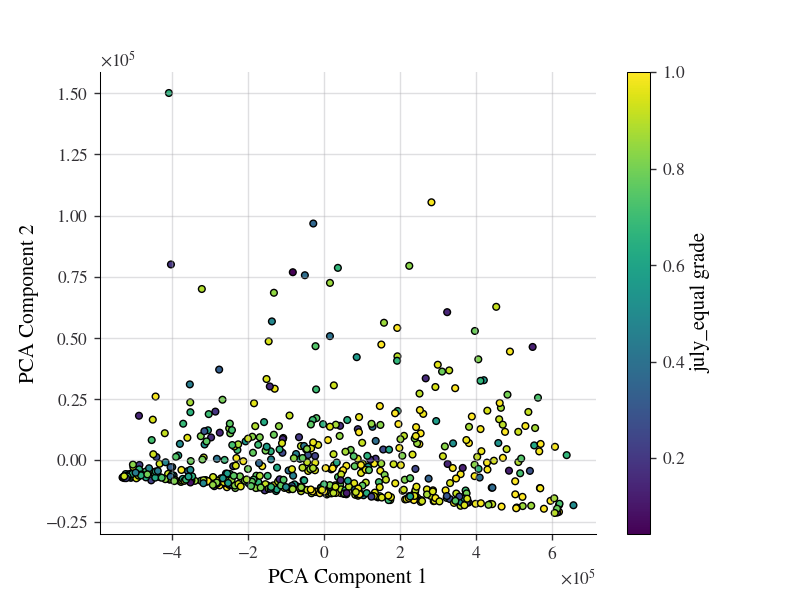

In [326]:
@interact(target=["july_equal", "other_equal"])
def pcainteract(target):
    pca = PCA(n_components=2, random_state=42)
    reduced_pca = pca.fit_transform(summary_features)
    plt.figure()
    plt.grid(alpha=0.4)
    plt.scatter(reduced_pca[:,0], reduced_pca[:,1], c=grades[target], s=15)
    plt.colorbar(label=f"{target} grade")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")

interactive(children=(Dropdown(description='target', options=('july_equal', 'other_equal'), value='july_equal'…

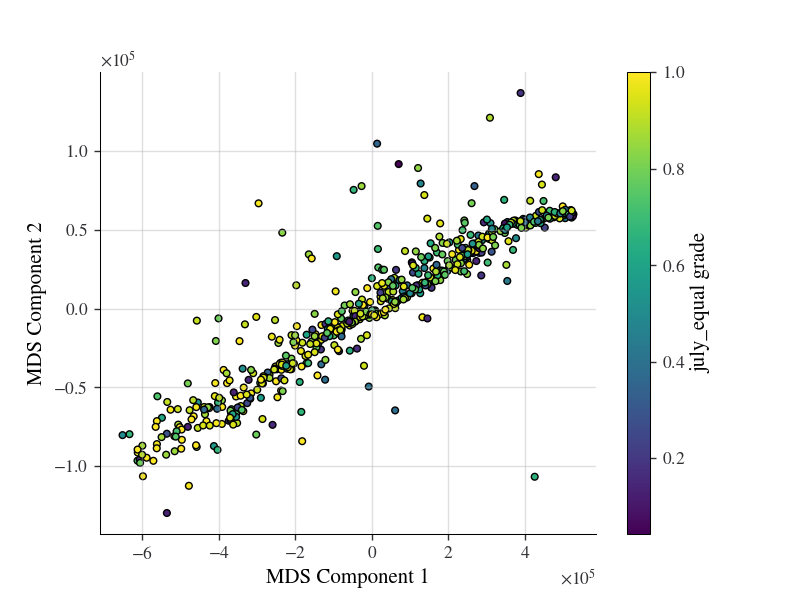

In [327]:
@interact(target=["july_equal", "other_equal"])
def mdsinteract(target):
    mds = MDS(n_components=2, random_state=42)
    reduced_mds = mds.fit_transform(summary_features)
    plt.figure()
    plt.grid(alpha=0.4)
    plt.scatter(reduced_mds[:,0], reduced_mds[:,1], c=grades[target], s=15)
    plt.colorbar(label=f"{target} grade")
    plt.xlabel("MDS Component 1")
    plt.ylabel("MDS Component 2")

### Correlations

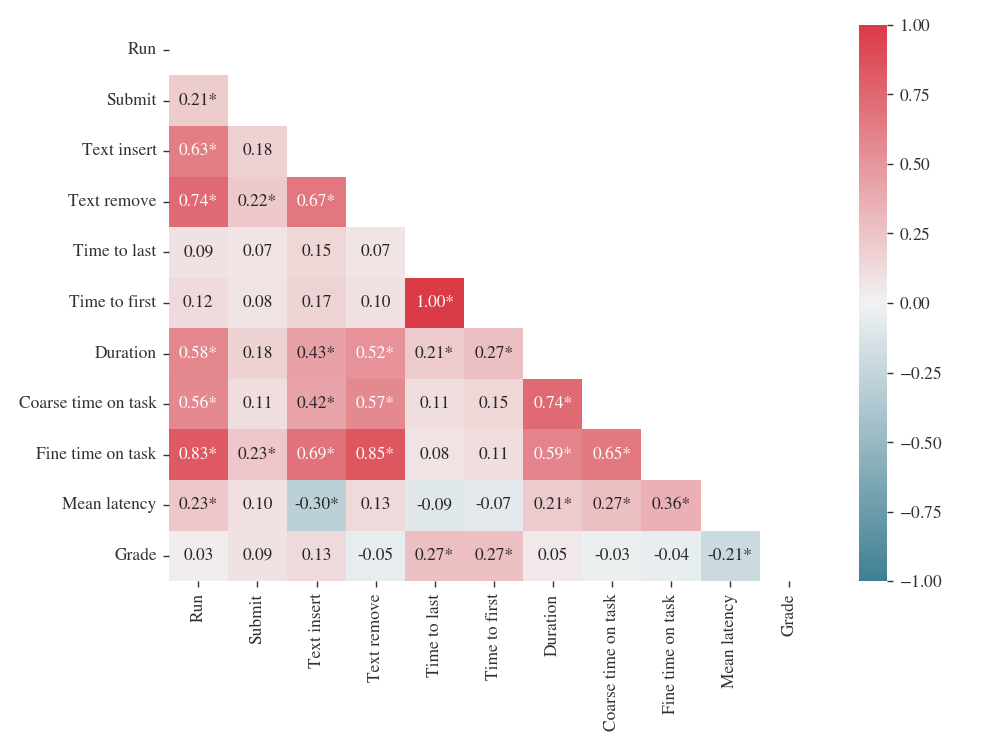

In [410]:
features = summary_features.assign(grade=grades.july_equal).loc[1]
features = features[['run', 'submit', 'text_insert', 'text_remove', 'time_to_last', 'time_to_first', 'duration', 'coarse_time_on_task', 'fine_time_on_task', 'mean_latency', 'grade']]

corr = features.corr(method='spearman')
p = features.corr(method=lambda x, y: stats.spearmanr(x,y)[1]).to_numpy()
# Bonferroni correction
p = multipletests(p.reshape(-1), alpha=0.05, method='bonferroni')[1].reshape(*p.shape)
corr = corr.rename(lambda name: name.replace("_", " ").capitalize()).T.rename(lambda name: name.replace("_", " ").capitalize()).T
plt.figure(figsize=(8,6))
annot = [[f"{val:.2f}{'*' if r < 0.05 else ''}" for val, r in zip(row, q)] for row, q in zip(corr.to_numpy(), p)]
matrix = np.triu(corr)
sns.heatmap(
    corr,
    annot=annot,
    mask=matrix,
    fmt='s',
    vmin=-1.,
    vmax=1.,
    cmap=sns.diverging_palette(220, 10, as_cmap=True)
)
plt.tight_layout()
plt.savefig('figures/correlations_sem1.pdf', bbox_inches='tight')
plt.savefig('figures/correlations_sem1.png', bbox_inches='tight');

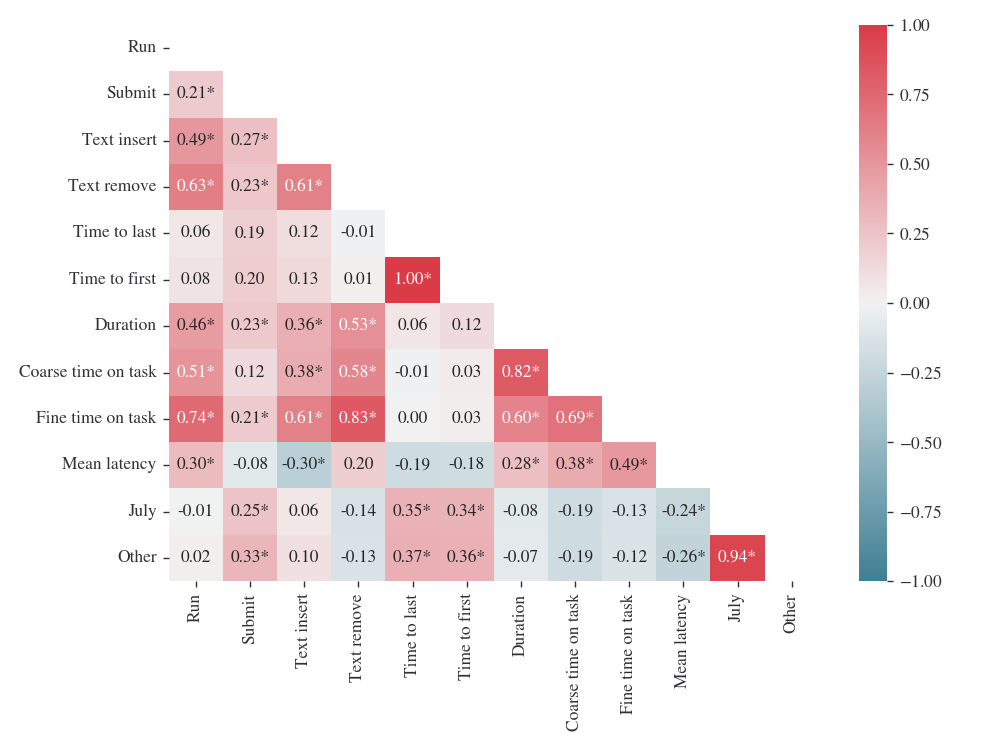

In [426]:
features = summary_features.assign(july=grades.july_equal, other=grades.other_equal).loc[2]
features = features[['run', 'submit', 'text_insert', 'text_remove', 'time_to_last', 'time_to_first', 'duration', 'coarse_time_on_task', 'fine_time_on_task', 'mean_latency', 'july', 'other']]

corr = features.corr(method='spearman')
p = features.corr(method=lambda x, y: stats.spearmanr(x,y)[1]).to_numpy()
# Bonferroni correction
p = multipletests(p.reshape(-1), alpha=0.05, method='bonferroni')[1].reshape(*p.shape)
corr = corr.rename(lambda name: name.replace("_", " ").capitalize()).T.rename(lambda name: name.replace("_", " ").capitalize()).T
plt.figure(figsize=(8,6))
annot = [[f"{val:.2f}{'*' if r < 0.05 else ''}" for val, r in zip(row, q)] for row, q in zip(corr.to_numpy(), p)]
matrix = np.triu(corr)
sns.heatmap(
    corr,
    annot=annot,
    mask=matrix,
    fmt='s',
    vmin=-1.,
    vmax=1.,
    cmap=sns.diverging_palette(220, 10, as_cmap=True)
)
plt.tight_layout()
plt.savefig('figures/correlations_sem2.pdf', bbox_inches='tight')
plt.savefig('figures/correlations_sem2.png', bbox_inches='tight');

## Distributions

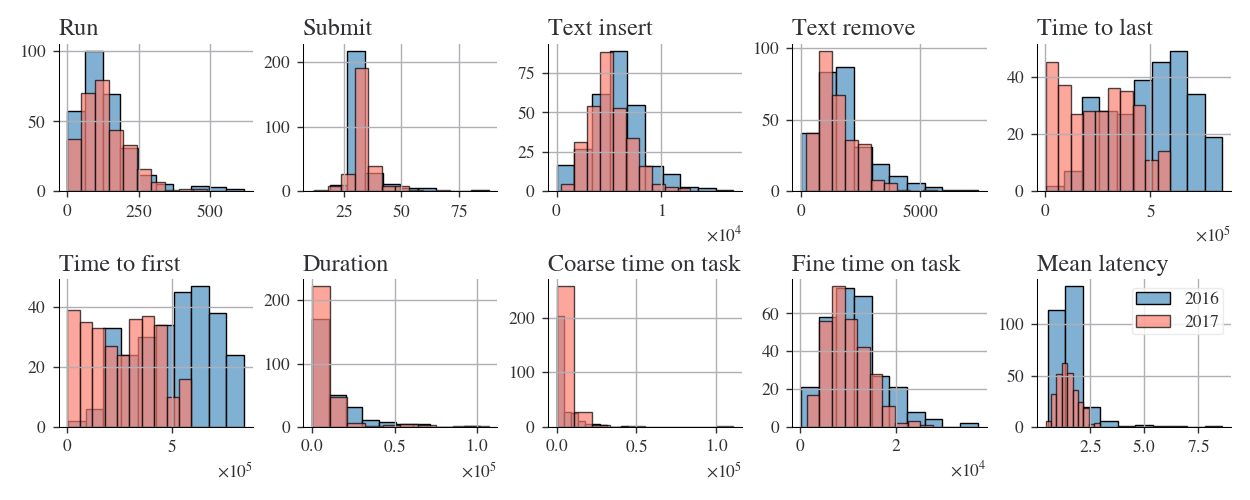

In [407]:
group1, group2 = summary_features.rename(lambda name: name.replace("_", " ").capitalize(), axis=1).groupby('semester')
axes = group1[1].hist(figsize=(10, 4), layout=(2,5), label='2016')
group2[1].hist(ax=axes.ravel()[:10], alpha=0.7, label='2017')
plt.tight_layout(h_pad=0.5, w_pad=0.6)
axes[-1,-1].legend()
plt.savefig('figures/distributions.pdf', bbox_inches='tight')
plt.savefig('figures/distributions.png', bbox_inches='tight')

In [386]:
import types; from math import ceil; import pickle

In [387]:
with open("large_summary_features.pickle", "rb") as f:
    large_summary_features = pickle.load(f)

In [388]:
combined_summary_features = pd.concat([
    #summary_features.assign(grouper=summary_features.index.get_level_values(0)),
    summary_features.assign(grouper=1),
    large_summary_features.assign(grouper=3)
])

/home/zac/.local/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6607: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/zac/.local/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6608: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

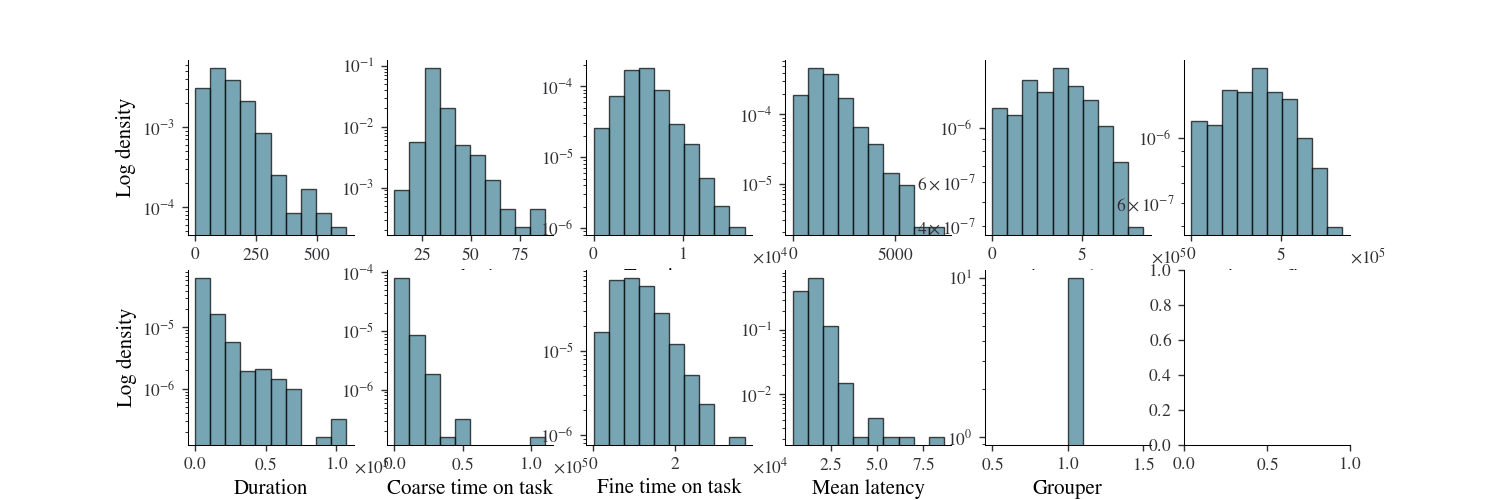

In [389]:
pad = plt.rcParams["xtick.major.size"] + plt.rcParams["xtick.major.pad"]
def bottom_offset(self, bboxes, bboxes2):
    bottom = self.axes.bbox.ymin
    self.offsetText.set(va="top", ha="left")
    oy = bottom - pad * self.figure.dpi / 72.0
    self.offsetText.set_position((1, oy))

fig, axes = plt.subplots(int(len(combined_summary_features.columns) / 6), 6, figsize=(12, 4))
for (name, semester), color in zip(combined_summary_features.groupby('grouper'), [cmap(0), cmap(255), cmap(124)]):
    for i, ((feature, data), ax) in enumerate(zip([(feat, data) for feat, data in semester.iteritems() if feat != "text_paste"], axes.flatten())):
        label = name#"train" if name == 1 else "test"
        ax.hist(data, label=label if i == 0 else None, color=color, density=True, log=True, alpha=0.7)
        ax.set_xlabel(feature.replace("_", " ").capitalize())
        if i % 6 == 0:
            ax.set_ylabel("Log density")
        ax.xaxis._update_offset_text_position = types.MethodType(bottom_offset, ax.xaxis)
#axes[-1][-1].set_visible(False)

fig.legend(frameon=False)#, loc='center', bbox_to_anchor=(0.96, 0.42))
fig.tight_layout(pad=0, h_pad=0.5, w_pad=0.2)

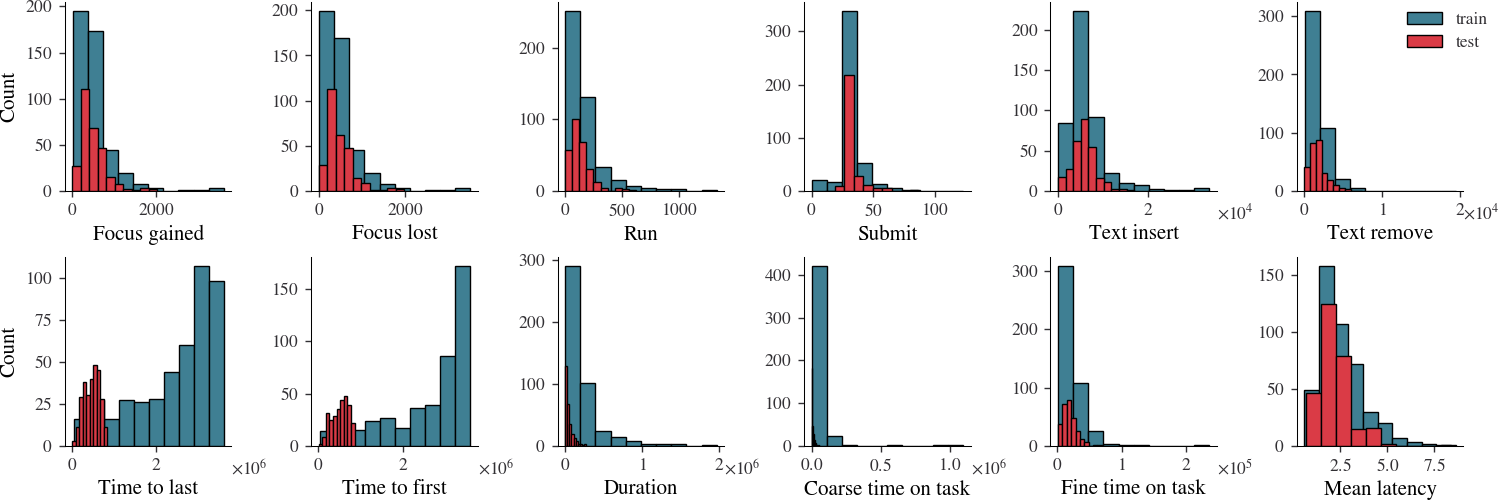

In [217]:
pad = plt.rcParams["xtick.major.size"] + plt.rcParams["xtick.major.pad"]
def bottom_offset(self, bboxes, bboxes2):
    bottom = self.axes.bbox.ymin
    self.offsetText.set(va="top", ha="left") 
    oy = bottom - pad * self.figure.dpi / 72.0
    self.offsetText.set_position((1, oy))

fig, axes = plt.subplots(int(len(summary_features.columns) / 6), 6, figsize=(12, 4))
for (name, semester), color in zip(summary_features.groupby('semester'), [cmap(0), cmap(255)]):
    for i, ((feature, data), ax) in enumerate(zip([(feat, data) for feat, data in semester.iteritems() if feat != "text_paste"], axes.flatten())):
        label = "train" if name == 1 else "test"
        ax.hist(data, label=label if i == 0 else None, color=color)
        ax.set_xlabel(feature.replace("_", " ").capitalize())
        if i % 6 == 0:
            ax.set_ylabel("Count")
        ax.xaxis._update_offset_text_position = types.MethodType(bottom_offset, ax.xaxis)
#axes[-1][-1].set_visible(False)

fig.legend(frameon=False)#, loc='center', bbox_to_anchor=(0.96, 0.42))
fig.tight_layout(pad=0, h_pad=0.5, w_pad=0.2)
fig.savefig('figures/hist_semester_comp.png', bbox_inches='tight')
fig.savefig('figures/hist_semester_comp.pdf', bbox_inches='tight');

## Split & Encoding

In [400]:
np.unique(np.around(grades.july_equal, 1), return_counts=True)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([  1,  17,  27,  21,  28,  30,  39,  59,  84, 136, 132]))

# Models

In [402]:
encoder = LabelEncoder()
encoder.fit(list(keystrokes.event_type.value_counts().index))

LabelEncoder()

In [427]:
@interact(
    summary_features=widgets.fixed(summary_features),
    grades=widgets.fixed(grades),
    model=widgets.Dropdown(options=[
        partial(RandomForestRegressor, random_state=42),
        LinearRegression,
        SVR,
        MLPRegressor,
        BayesianRidge
    ]),
    split=widgets.Dropdown(options=['train_test_sem_1', 'train_test_sem_2', '5fold_sem_1', '5fold_sem_2', '2sem']),
    target=widgets.Dropdown(options=grades.columns, value='july_equal'),
    plot_importance=False,
    plot_scatter=False,
    norm=False,
    random_state=42
)
def evaluate_regression(summary_features, grades, model, split, plot_importance, norm, plot_scatter, target, random_state, silent=False):
    train_ids, test_ids = train_test_split(keystrokes.loc[1].index.unique(), test_size=0.5, random_state=random_state)
    
    features = pd.DataFrame(Normalizer().fit_transform(summary_features), index=summary_features.index, columns=summary_features.columns) if norm else summary_features
    
    if split == 'train_test_sem_1' or split == 'train_test_sem_2':
        sem = int(split[-1])
        summary_train = [features.loc[sem][features.loc[sem].index.isin(train_ids)]]
        summary_test = [features.loc[sem][features.loc[sem].index.isin(test_ids)]]
        grades_train = [grades[target].loc[sem][grades.loc[sem].index.isin(train_ids)]]
        grades_test = [grades[target].loc[sem][grades.loc[sem].index.isin(test_ids)]]
    elif split == '5fold_sem_1' or split == '5fold_sem_2':
        #sem_2_cols = ['run', 'submit', 'text_insert', 'text_remove', 'time_to_last', 'time_to_first', 'duration', 'coarse_time_on_task', 'fine_time_on_task', 'mean_latency']
        sem = int(split[-1])
        folds = KFold(random_state=random_state, shuffle=True)
        summary_train = []
        summary_test = []
        grades_train = []
        grades_test = []
        for train_ids, test_ids in folds.split(features.loc[sem]):
            summary_train_ = features.loc[sem][features.loc[sem].index.isin(train_ids)]
            summary_test_ = features.loc[sem][features.loc[sem].index.isin(test_ids)]
            grades_train_ = grades[target].loc[sem][grades.loc[sem].index.isin(train_ids)]
            grades_test_ = grades[target].loc[sem][grades.loc[sem].index.isin(test_ids)]
        
            summary_train.append(summary_train_)
            summary_test.append(summary_test_)
            grades_train.append(grades_train_)
            grades_test.append(grades_test_)
    elif split == '2sem':
        # some features not available in sem 2 so we filter them out of our training data
        #sem_2_cols = ['run', 'submit', 'text_insert', 'text_remove', 'time_to_last', 'time_to_first', 'duration', 'coarse_time_on_task', 'fine_time_on_task', 'mean_latency']
        summary_train = [summary_features.loc[1]]
        summary_test = [summary_features.loc[2]]
        grades_train = [grades[target].loc[1]]
        grades_test = [grades[target].loc[2]]
        
    r2s = []
    adj_r2s = []
    for summary_train_, summary_test_, grades_train_, grades_test_ in zip(summary_train, summary_test, grades_train, grades_test):
        clf = model()
        clf.fit(summary_train_, grades_train_)
        predicted = clf.predict(summary_test_)
        r2 = r2_score(grades_test_, predicted)
        adj_r2 = 1-(1-r2)*(summary_test_.shape[0]-1)/(summary_test_.shape[0]-summary_test_.shape[1]-1)
        r2s.append(r2)
        adj_r2s.append(adj_r2)
        
        if not silent:
            print(f"For target {target}:")
            print("r^2", r2)
            print(f"adjusted r^2 {adj_r2}")
    
    if plot_importance:
        plt.figure()
        plt.bar(summary_train.columns, clf.feature_importances_)
        plt.xticks(rotation='vertical')
        plt.grid(alpha=0.4)
        plt.tight_layout()
        plt.show()
        
    if plot_scatter:
        plt.figure()
        plt.scatter(predicted, grades_test)
        plt.xlabel("Predicted")
        plt.ylabel("Final Grade")
        plt.grid(alpha=0.4)
        plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='grey', ls='--')
        plt.show()
    
    return np.mean(r2s), np.mean(adj_r2s)

interactive(children=(Dropdown(description='model', options=(functools.partial(<class 'sklearn.ensemble._fores…

In [424]:
@interact_manual(
    summary_features=widgets.fixed(summary_features),
    grades=widgets.fixed(grades),
    model=widgets.Dropdown(options=[partial(RandomForestRegressor, random_state=42), LinearRegression]),
    split=widgets.Dropdown(options=['train_test_sem_1', 'train_test_sem_2', '5fold_sem_1', '5fold_sem_2', '2sem']),
    target=widgets.Dropdown(options=grades.columns, value='july_equal'),
    plot_importance=False,
    plot_scatter=False,
    norm=False,
    count=widgets.IntSlider(min=100,max=2000, step=100, value=100)
)
def bootstrap_regression(summary_features, grades, model, split, plot_importance, norm, plot_scatter, target, count=100):
    adj_r2s = []
    r2s = []
    for i in range(count):
        mask = np.random.choice(summary_features.shape[0], size=summary_features.shape[0], replace=True)
        X = summary_features.iloc[mask]
        y = grades.iloc[mask]
        r2, adj_r2 = evaluate_regression(X, y, model, split, plot_importance, norm, plot_scatter, target, random_state=i, silent=True)
        adj_r2s.append(adj_r2)
        r2s.append(r2)
    
    plt.figure()
    plt.hist(adj_r2s, color=cmap(0))
    plt.axvline(np.mean(adj_r2s), ls='--', color='grey')
    print("mean adj r2", np.mean(adj_r2s))
    print("std adj r2", np.std(adj_r2s))
    print("lower adj r2", np.quantile(adj_r2s, .025))
    print("upper adj r2", np.quantile(adj_r2s, .975))
    print("norm fit adj r2", stats.norm.fit(adj_r2s))
    print("mean r2", np.mean(r2s))
    print("std r2", np.std(r2s))
    print("lower r2", np.quantile(r2s, .025))
    print("upper r2", np.quantile(r2s, .975))
    print("norm fit r2", stats.norm.fit(r2s))
    plt.xlabel('adjusted r^2')
    plt.ylabel('Count')
    plt.grid(alpha=0.4)
    plt.show()
    plt.savefig('figures/bootstrap.png', bbox_inches='tight')
    plt.savefig('figures/bootstrap.pdf', bbox_inches='tight')

interactive(children=(Dropdown(description='model', options=(functools.partial(<class 'sklearn.ensemble._fores…

In [75]:
@interact(
    model=widgets.Dropdown(options=[partial(RandomForestClassifier, random_state=42), LogisticRegression]),
    selected_features=widgets.SelectMultiple(options=list(summary_features.columns), value=list(summary_features.columns)),
    split=widgets.Dropdown(options=['train_test_sem_1', 'train_test_sem_2', '5fold_sem_1', '5fold_sem_2', '2sem']),
    target=widgets.Dropdown(options=grades.columns, value='july_equal'),
    setting=widgets.Dropdown(options=['==5', 'all']),
    plot_importance=False,
    plot_confusion=False,
    plot_roc=False,
    norm=False,
)
def evaluate_classification(model, selected_features, split, target, setting, plot_importance, plot_confusion, plot_roc, norm):
    features = pd.DataFrame(Normalizer().fit_transform(summary_features), index=summary_features.index, columns=summary_features.columns) if norm else summary_features
    
    if split == 'train_test_sem_1' or split == 'train_test_sem_2':
        train_ids, test_ids = train_test_split(keystrokes.loc[1].index.unique(), test_size=0.5, random_state=42)
        sem = int(split[-1])
        summary_train = [features.loc[sem][features.loc[sem].index.isin(train_ids)][list(selected_features)]]
        summary_test = [features.loc[sem][features.loc[sem].index.isin(test_ids)][list(selected_features)]]
        grades_train = grades[target].loc[sem][grades.loc[sem].index.isin(train_ids)]
        grades_test = grades[target].loc[sem][grades.loc[sem].index.isin(test_ids)]
        
        if sem == 1:
            grades_train = [pd.cut(grades_train, [0., 0.51, 0.61, 0.71, 0.81, 0.91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)]
            grades_test = [pd.cut(grades_test, [0., 0.51, 0.61, 0.71, 0.81, 0.91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)]
        else:
            grades_train = [pd.cut(grades_train, [0., .7, .76, .81, .86, .91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)]
            grades_test = [pd.cut(grades_test, [0., .7, .76, .81, .86, .91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)]
        
    elif split == '5fold_sem_1' or split == '5fold_sem_2':
        sem = int(split[-1])
        folds = KFold(random_state=42, shuffle=True)
        summary_train = []
        summary_test = []
        grades_train = []
        grades_test = []
        for train_ids, test_ids in folds.split(features.loc[sem]):
            summary_train_ = features.loc[sem][features.loc[sem].index.isin(train_ids)][list(selected_features)]
            summary_test_ = features.loc[sem][features.loc[sem].index.isin(test_ids)][list(selected_features)]
            grades_train_ = grades[target].loc[sem][grades.loc[sem].index.isin(train_ids)]
            grades_test_ = grades[target].loc[sem][grades.loc[sem].index.isin(test_ids)]
        
            if sem == 1:
                grades_train_ = pd.cut(grades_train_, [0., 0.51, 0.61, 0.71, 0.81, 0.91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)
                grades_test_ = pd.cut(grades_test_, [0., 0.51, 0.61, 0.71, 0.81, 0.91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)
            else:
                grades_train_ = pd.cut(grades_train_, [0., .7, .76, .81, .86, .91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)
                grades_test_ = pd.cut(grades_test_, [0., .7, .76, .81, .86, .91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)
            summary_train.append(summary_train_)
            summary_test.append(summary_test_)
            grades_train.append(grades_train_)
            grades_test.append(grades_test_)
            
    elif split == '2sem':
        # some features not available in sem 2 so we filter them out of our training data
        sem_2_cols = ['run', 'submit', 'text_insert', 'text_remove', 'time_to_last', 'time_to_first', 'duration', 'coarse_time_on_task', 'fine_time_on_task', 'mean_latency']
        summary_train = [summary_features.loc[1][sem_2_cols][list(selected_features)]]
        summary_test = [summary_features.loc[2][sem_2_cols][list(selected_features)]]
        grades_train = grades.final.loc[1]
        grades_test = grades.final.loc[2]
        
        grades_train = [pd.cut(grades_train, [0., 0.51, 0.61, 0.71, 0.81, 0.91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)]
        grades_test = [pd.cut(grades_test, [0., .7, .76, .81, .86, .91, 1.], labels=[0,1,2,3,4,5], include_lowest=True)]
        
    if setting == '==5':
        for i in range(len(grades_train)):
            grades_train[i] = grades_train[i] == 5
            grades_test[i] = grades_test[i] == 5
        
    pred = []
    expected = []
    pred_proba = []
    for summary_train_, summary_test_, grades_train_, grades_test_ in zip(summary_train, summary_test, grades_train, grades_test):
        clf = model()
        clf.fit(summary_train_, grades_train_)
        predicted = clf.predict(summary_test_)
        predicted_proba = clf.predict_proba(summary_test_)
        pred.append(predicted)
        pred_proba.append(predicted_proba)
        expected.append(grades_test_)
        
    #print(expected, pred)
    print(classification_report(pd.concat(expected), np.concatenate(pred)))
    print(f"ROC AUC {roc_auc_score(pd.concat(expected), np.concatenate(pred)):.2f}")
    print(f"F1 {f1_score(pd.concat(expected), np.concatenate(pred)):.2f}")
    
    if plot_importance:
        plt.figure()
        plt.bar(summary_train[0].columns, clf.feature_importances_)
        plt.xticks(rotation='vertical')
        plt.grid(alpha=0.4)
        plt.tight_layout()
        plt.show()
        
    if plot_roc:
        fpr, tpr, _ = roc_curve(pd.concat(expected), np.concatenate(pred_proba)[:,1])
        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0,1], [0,1], ls='--', color='grey')
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.grid(alpha=0.4)
        plt.tight_layout()
        plt.show()
        
    if plot_confusion:
        plt.figure()
        #plt.scatter(grades_test, predicted)
        #plt.xlabel("Final Grade")
        #plt.ylabel("Predicted")
        #plt.grid(alpha=0.4)
        #plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='grey', ls='--')
        #plt.show()

interactive(children=(Dropdown(description='model', options=(functools.partial(<class 'sklearn.ensemble._fores…

---

In [76]:
clf = RandomForestRegressor()
clf.fit(summary_features_norm[summary_features.index.isin(train_ids)], grades.grade[train_ids])
predicted = clf.predict(summary_features_norm[summary_features.index.isin(test_ids)])
r2_score(grades.grade[test_ids], predicted)

NameError: name 'summary_features_norm' is not defined

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

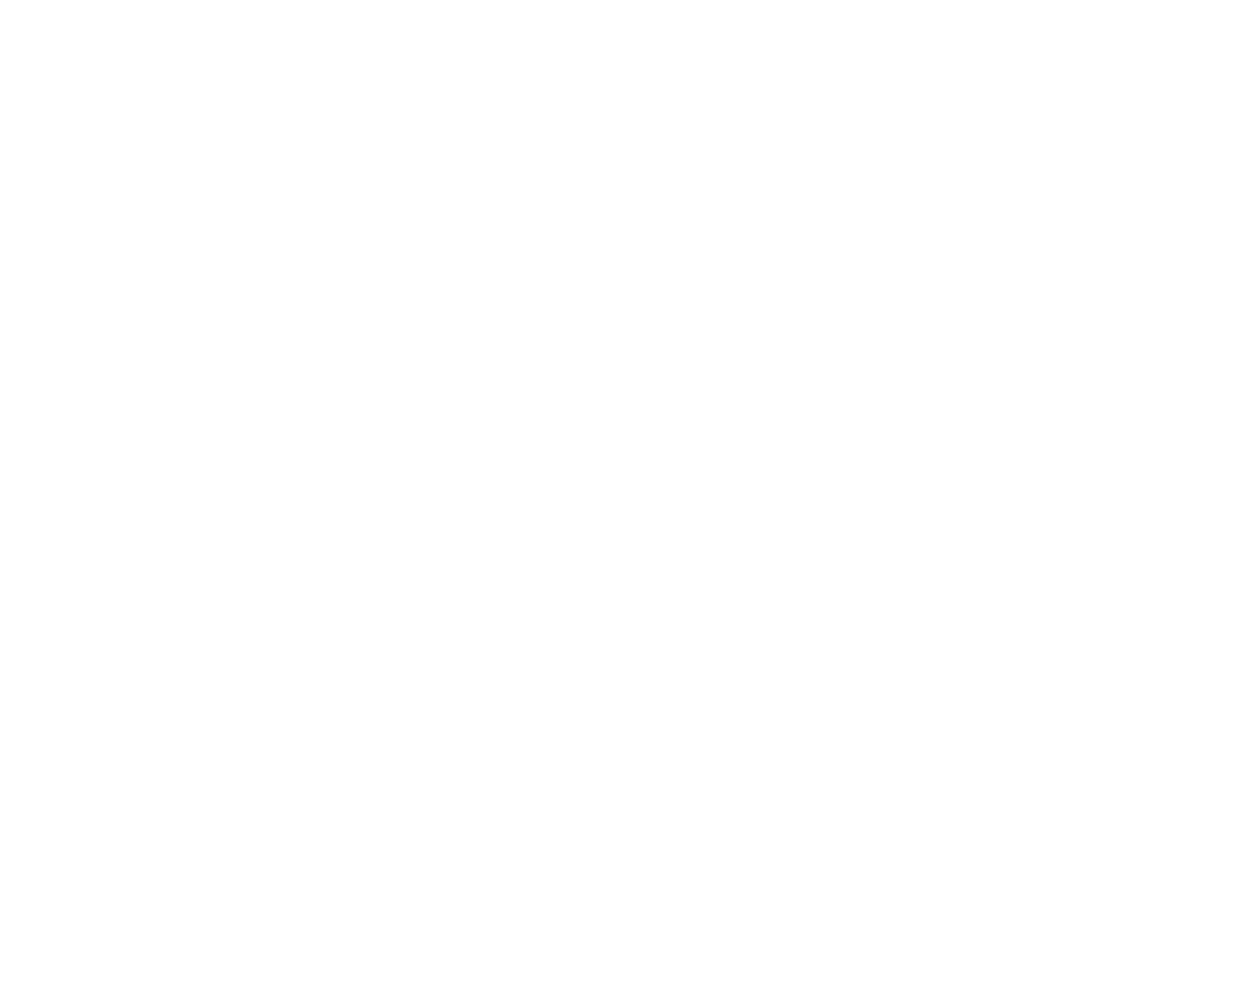

In [77]:
plt.figure(figsize=(10,8))
plt.bar(summary_features.columns, clf.feature_importances_)
plt.xticks(rotation='vertical')
plt.grid(alpha=0.4)
plt.tight_layout();

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(grades.grade[test_ids], predicted)
plt.xlabel("Final Grade")
plt.ylabel("Predicted")
plt.grid(alpha=0.4)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='grey', ls='--');

In [ ]:
sns.diverging_palette(220, 10, as_cmap=True)

In [ ]:
fig, axes = plt.subplots(len(summary_train.columns) // 5, 5, figsize=(12,5))
for semester, name, color in zip([summary_train, summary_test], ["MOOC", "Local University"], [cmap(0), cmap(256)]):
    for i, ((feature, data), ax) in enumerate(zip(semester.iteritems(), axes.flatten())):
        ax.hist(data, label=name, color=color)
        ax.set_xlabel(feature)
        if i % 5 == 0:
            ax.set_ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig('figures/hist_semester_comp.png', bbox_inches='tight')
plt.savefig('figures/hist_semester_comp.pdf', bbox_inches='tight');

In [ ]:
fig, axes = plt.subplots(len(summary_train.columns) // 5, 5, figsize=(12,5))
for semester, name, color in zip([summary_train, summary_test], ["train", "test"], [cmap[0], cmap[-1]]):
    for i, ((feature, data), ax) in enumerate(zip(semester.iteritems(), axes.flatten())):
        ax.hist(data, label=name, color=color)
        ax.set_xlabel(feature)
        if i % 5 == 0:
            ax.set_ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig('figures/hist_semester_comp.png', bbox_inches='tight')
plt.savefig('figures/hist_semester_comp.pdf', bbox_inches='tight');